In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import yfinance as yf
from datetime import datetime
import pandas as pd
import psycopg2
import configparser
import datetime
import nbimporter
from Connection_to_pgAdmin4 import *
from SQL import *

In [30]:

# Function to execute SQL queries
#SQL REFERENCE A


def execute_sql_query(query, params=None):
    
    # Establish a connection to the database
    connection = connect_to_database()

    try:
        if connection:
            cursor = connection.cursor()
            
            # Execute the SQL query
            if params:
                cursor.execute(query, params)
            else:
                cursor.execute(query)

            # If it's a SELECT query, fetch the results
            if query.strip().lower().startswith("select"):
                results = cursor.fetchall()
                cursor.close()
                return results

            # For other types of queries, commit the changes
            else:
                connection.commit()
               # print("Query executed successfully.")

    except (Exception, psycopg2.Error) as error:
        print(f"Error: {error}")
        if connection:
            connection.rollback()

    finally:
        if connection:
            connection.close()


In [31]:
# Function to fetch financial information for the last 3 months from the database.
def fetch_financial_info():
    # SQL query to select data from the last 3 months, ordered by Date and Symbol.
    query = """
    SELECT Date, Symbol, Open, High, Low, Close, Volume
    FROM dimension.d_financial_info
    WHERE Date > CURRENT_DATE - INTERVAL '5 months'
    ORDER BY Date DESC, Symbol
    """
    
    # Execute the SQL query and store the result.
    financial_data = execute_sql_query(query)
    
    # Check if the query returned any data.
    if financial_data:
        # Define column names for the pandas DataFrame.
        columns = ['Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume']
        
        # Create a pandas DataFrame with the financial data.
        df = pd.DataFrame(financial_data, columns=columns)
        
        # Print the count of NaN values in each column.
        print(df.isnull().sum())  
        
        # Fill NaN values with zero. Alternative handling could be to use the mean.
        df.fillna(0, inplace=True)
        
        # Return the DataFrame with financial data.
        return df
    else:
        # Return None if no data was found.
        return None



In [32]:
data = fetch_financial_info()

Date       0
Symbol     0
Open      62
High      62
Low       62
Close     62
Volume     0
dtype: int64


In [33]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(0, 1))

In [34]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), :])  # Note the :, indicating all features are included
        y.append(data[i + sequence_length, :])  # Assuming y also has multiple features; adjust as needed
    return np.array(X), np.array(y)


In [35]:
print(data.columns)


Index(['Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

sequence_length = 40
symbol_data = {}  # For storing train/test splits and scalers by symbol

minimum_samples = sequence_length + 1  # Minimum samples needed to form a sequence

for symbol in symbols:
    symbol_df = data[data['Symbol'] == symbol]
    
    # Check if the number of samples is sufficient
    if len(symbol_df) < minimum_samples:
        print(f"Skipping {symbol}: Not enough data.")
        continue  # Skip this symbol and move to the next one
    
    features = symbol_df[['Open', 'High', 'Low', 'Close', 'Volume']]
    
    # Split your data first to avoid data leakage
    features_train, features_test = train_test_split(features, test_size=0.2, random_state=42)
    
    # Scale based on training data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features_train = scaler.fit_transform(features_train)
    scaled_features_test = scaler.transform(features_test)  # Transform test data based on training data scaler
    
    # Assuming create_sequences is a function you've defined to create sequences from the scaled data
    X_train, y_train = create_sequences(scaled_features_train, sequence_length)
    X_test, y_test = create_sequences(scaled_features_test, sequence_length)
    
    symbol_data[symbol] = {
        'X_train': X_train, 'y_train': y_train,
        'X_test': X_test, 'y_test': y_test,
        'scaler': scaler  # Storing scaler might be useful for inverse transforming predictions later
    }


Skipping 0DOG.L: Not enough data.
Skipping 0DP0.L: Not enough data.
Skipping 0DRH.L: Not enough data.
Skipping 0DVR.L: Not enough data.
Skipping 0E4F.L: Not enough data.
Skipping 0E76.L: Not enough data.
Skipping 0EMB.L: Not enough data.
Skipping 0F3G.L: Not enough data.
Skipping 0FLE.L: Not enough data.
Skipping 0FMN.L: Not enough data.
Skipping 0FMO.L: Not enough data.
Skipping 0FQS.L: Not enough data.
Skipping 0FRE.L: Not enough data.
Skipping 0FT3.L: Not enough data.
Skipping 0G6W.L: Not enough data.
Skipping 0HFP.L: Not enough data.
Skipping 0HOV.L: Not enough data.
Skipping 0J0H.L: Not enough data.
Skipping 0JFT.L: Not enough data.
Skipping 0JI3.L: Not enough data.
Skipping 0JJP.L: Not enough data.
Skipping 0K9U.L: Not enough data.
Skipping 0KO8.L: Not enough data.
Skipping 0LOA.L: Not enough data.
Skipping 0LRI.L: Not enough data.
Skipping 0LRV.L: Not enough data.
Skipping 0LV3.L: Not enough data.
Skipping 0LVL.L: Not enough data.
Skipping 0LX1.L: Not enough data.
Skipping 0MN3.

In [39]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

def build_model(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        LSTM(units=50),
        Dense(units=5)  # Predicting 'Open', 'High', 'Low', 'Close', 'Volume'
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

for symbol, data in symbol_data.items():
    X_train, y_train = data['X_train'], data['y_train']
    X_test, y_test = data['X_test'], data['y_test']
    
    if len(X_test) == 0 or len(y_test) == 0:
        print(f"Skipping evaluation for {symbol} due to empty test set.")
        continue  # Skip this symbol to avoid ValueError
    
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    model = build_model(input_shape)
    print(f"Training model for {symbol}...")
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)
    
    print(f"Evaluating model for {symbol}...")
    model.evaluate(X_test, y_test)
    
    # Generate predictions
    predictions = model.predict(X_test)
    # Optional: Inverse transform your predictions here if you've applied scaling to your features
    
    # Print predictions for each symbol
    print(f"Predictions for {symbol}:")
    for i, prediction in enumerate(predictions[:5]):  # Adjust the range as needed
        print(f"Sample {i+1}: {prediction}")


Skipping evaluation for 0A0B.L due to empty test set.
Skipping evaluation for 0A0C.L due to empty test set.
Skipping evaluation for 0A1H.L due to empty test set.
Skipping evaluation for 0A1U.L due to empty test set.
Skipping evaluation for 0A2K.L due to empty test set.
Skipping evaluation for 0A3R.L due to empty test set.
Skipping evaluation for 0A3T.L due to empty test set.
Skipping evaluation for 0A5J.L due to empty test set.
Skipping evaluation for 0A60.L due to empty test set.
Skipping evaluation for 0A6L.L due to empty test set.
Skipping evaluation for 0AA3.L due to empty test set.
Skipping evaluation for 0AH7.L due to empty test set.
Skipping evaluation for 0AI4.L due to empty test set.
Skipping evaluation for 0APM.L due to empty test set.
Skipping evaluation for 0B67.L due to empty test set.
Skipping evaluation for 0BJP.L due to empty test set.
Skipping evaluation for 0BNT.L due to empty test set.
Skipping evaluation for 0BOE.L due to empty test set.
Skipping evaluation for 0BQE

KeyboardInterrupt: 

In [4]:
# Function to preprocess financial data along with symbols and dates for LSTM model input.
# Window Size 30
def preprocess_data_with_symbols(df, seq_length=30):
    # Initialise a MinMaxScaler to scale features between 0 and 1.
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Get unique symbols from the DataFrame.
    symbols = df['Symbol'].unique()
    
    # Lists to store processed sequences, their corresponding symbols, and dates.
    processed_data = []
    sequence_symbols = []  # Keeps track of symbols for each processed sequence.
    sequence_dates = []  # Keeps track of the date for the last data point in each sequence.
    
    # Iterate over each symbol to process data symbol-wise.
    for symbol in symbols:
        # Create a copy of the DataFrame filtered by current symbol and sort it by date.
        data_symbol = df[df['Symbol'] == symbol].copy()
        data_symbol.sort_values(by='Date', inplace=True)
        
        # Scale the features (Open, High, Low, Close, Volume) for the current symbol.
        scaled_features = scaler.fit_transform(data_symbol[['Open', 'High', 'Low', 'Close', 'Volume']])
        
        # Generate sequences of length 'seq_length' for LSTM input.
        for i in range(len(scaled_features) - seq_length):
            # Each sequence contains 'seq_length' consecutive days of data.
            seq = scaled_features[i:i + seq_length + 1]
            processed_data.append(seq)
            sequence_symbols.append(symbol)  # Associate the current symbol with the sequence.
            # Associate the date of the last data point in the sequence.
            sequence_dates.append(data_symbol.iloc[i + seq_length - 1]['Date'])
            
    # Return the processed sequences, scaler, symbols, and dates as a tuple.
    return np.array(processed_data), scaler, sequence_symbols, sequence_dates



In [5]:
# Defines a function to build an LSTM model with a specified input shape.

def build_model(input_shape):
    # Initialises a Sequential model.
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),  # First LSTM layer with 50 units, returns sequences for further layers.
        LSTM(50),  # Second LSTM layer with 50 units.
        Dense(5)  # Dense layer with 5 units for output, matching the number of predicted features.
    ])
    
    # Compiles the model with the Adam optimizer and mean squared error loss function.
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Returns the compiled model.
    return model


In [6]:
# Main function to execute the model pipeline.
def main():
    # Fetch financial information from the database for the last 3 months.
    df = fetch_financial_info()
    
    # Check if the DataFrame is not empty.
    if df is not None:
        # Preprocess the data to prepare sequences for LSTM model training.
        
        # This includes scaling of features and associating symbols and dates with each sequence.
        processed_data, scaler, sequence_symbols, sequence_dates = preprocess_data_with_symbols(df)
        
        # Shuffle the sequences to randomize the order before splitting into training and testing sets.
        # This step helps in generalizing the model by training on a random sample of sequences.
        indices = np.arange(processed_data.shape[0])
        np.random.shuffle(indices)
        processed_data = processed_data[indices]
        sequence_symbols = np.array(sequence_symbols)[indices]
        sequence_dates = np.array(sequence_dates)[indices]  # Matching dates are shuffled similarly to maintain alignment.
        
        # Split the data into training and testing sets, maintaining an 80-20 split.
        train_size = int(len(processed_data) * 0.8)
        X_train, y_train = processed_data[:train_size, :-1], processed_data[:train_size, -1][:, :5]
        X_test, y_test = processed_data[train_size:, :-1], processed_data[train_size:, -1][:, :5]
        # Extract symbols and dates for the test set to correlate predictions with specific symbols and dates.
        test_symbols = sequence_symbols[train_size:]
        test_dates = sequence_dates[train_size:]
        
        # Initialize and train the LSTM model on the training set.
        model = build_model((X_train.shape[1], X_train.shape[2]))
        history = model.fit(X_train, y_train, epochs=20, batch_size=30, validation_split=0.1, verbose=1)
        
        # Evaluate the model's performance on the test set.
        loss = model.evaluate(X_test, y_test, verbose=1)
        
        # Generate predictions for the test set using the trained model.
        predictions = model.predict(X_test)
        
        # Save model 
        model.save('PredictiveModel6_30days_sequense.h5')

        
        # Return a dictionary containing the test set, predictions, model information, and associated symbols and dates.
        # This comprehensive return structure allows for detailed analysis and further processing of the model's predictions.
        return {
            "X_test": X_test,  # Input features for the test set
            "y_test": y_test,  # True output values for the test set
            "predictions": predictions,  # Predicted output values by the model
            "scaler": scaler,  # Scaler object for inverse transformation of predictions
            "model": model,  # Trained LSTM model
            "history": history,  # Training history for analysis
            "loss": loss,  # Loss on the test set for evaluation
            "test_symbols": test_symbols,  # Symbols associated with the test set
            "test_dates": test_dates  # Dates associated with the test set predictions
        }
    else:
        # If no financial data is found, print a message and return None.
        print("No financial data found for the given period.")
        return None


In [7]:
results = main()

Date       0
Symbol     0
Open      47
High      47
Low       47
Close     47
Volume     0
dtype: int64
Epoch 1/20
3363/3363 [==============================] - 54s 16ms/step - loss: 0.0256 - val_loss: 0.0239
Epoch 2/20
3363/3363 [==============================] - 55s 16ms/step - loss: 0.0223 - val_loss: 0.0226
Epoch 3/20
3363/3363 [==============================] - 57s 17ms/step - loss: 0.0215 - val_loss: 0.0221
Epoch 4/20
3363/3363 [==============================] - 51s 15ms/step - loss: 0.0207 - val_loss: 0.0213
Epoch 5/20
3363/3363 [==============================] - 51s 15ms/step - loss: 0.0201 - val_loss: 0.0206
Epoch 6/20
3363/3363 [==============================] - 52s 15ms/step - loss: 0.0197 - val_loss: 0.0199
Epoch 7/20
3363/3363 [==============================] - 51s 15ms/step - loss: 0.0193 - val_loss: 0.0196
Epoch 8/20
3363/3363 [==============================] - 51s 15ms/step - loss: 0.0190 - val_loss: 0.0194
Epoch 9/20
3363/3363 [==============================] - 51s 15ms

/Users/shabanyounas/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
if results:
    # Inverse transform the predictions and true values to their original scale
    predictions_inverse = results['scaler'].inverse_transform(results['predictions'])
    
    y_test_inverse = results['scaler'].inverse_transform(results['y_test'])

    # Print the first few predictions vs. true values for comparison
    print("Predictions vs. True Values:")
    for i in range(10):  # Adjust the range as needed
        print(f"Prediction {i+1}: {predictions_inverse[i]}, True Value {i+1}: {y_test_inverse[i]}")

Predictions vs. True Values:
Prediction 1: [0.75062716 0.7682189  0.92321235 0.8839208  2.0483284 ], True Value 1: [1.11       1.11       1.02473038 0.9974579  2.05015419]
Prediction 2: [0.8536156  0.8283676  0.9058107  0.90246755 2.0816116 ], True Value 2: [0.91434783 0.91434783 0.97440678 1.08826087 2.06872938]
Prediction 3: [0.6718675 0.6659137 0.6470495 0.6481955 2.1395044], True Value 3: [0.87208178 0.84245937 0.69571429 0.66087719 2.25878054]
Prediction 4: [0.78626734 0.7877854  0.7536857  0.75744843 2.1853728 ], True Value 4: [0.88403846 0.87160338 0.90115226 0.89097345 2.005743  ]
Prediction 5: [0.50117904 0.51301384 0.46386555 0.48730817 2.154044  ], True Value 5: [0.45375    0.44660131 0.40846154 0.45355828 2.17226454]
Prediction 6: [0.9044674  0.87189174 0.81195694 0.88654876 2.2313485 ], True Value 6: [0.90674797 0.73007063 0.79789263 0.90527559 2.00000538]
Prediction 7: [0.60199285 0.15814564 0.6003352  0.65712816 2.099856  ], True Value 7: [0.61       0.11       0.61     

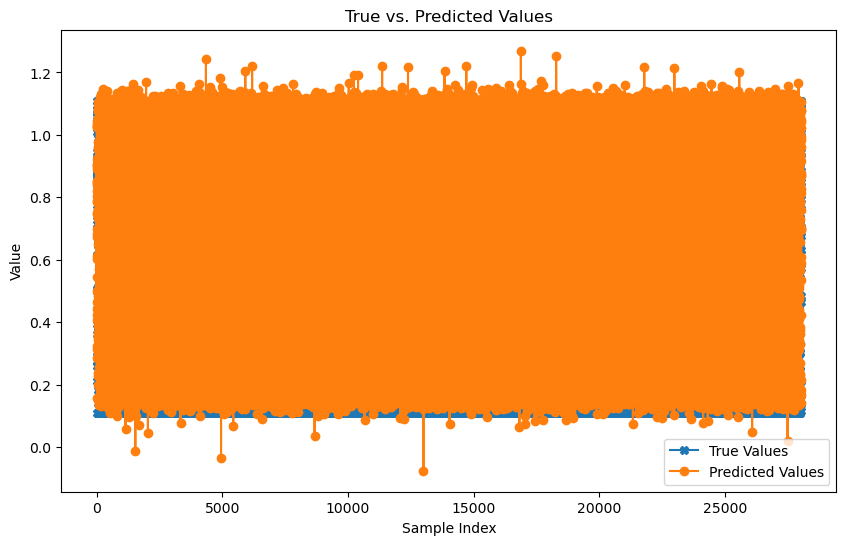

In [9]:
import matplotlib.pyplot as plt

# Check if the results from the model are available.
if results:
    # Initialise a new figure for plotting with dimensions 10x6 inches.
    plt.figure(figsize=(10, 6))
    
    # Plot the true values for the first feature across all samples in the test set,
    # marking each point with an 'X'.
    plt.plot(y_test_inverse[:, 0], label='True Values', marker='X')  # The first feature is selected with [:, 0].
    
    # Plot the predicted values for the same feature, using circles ('o') to mark each predicted point.
    plt.plot(predictions_inverse[:, 0], label='Predicted Values', marker='o')  # Likewise, focusing on the first feature.
    
    # Set the title of the plot to indicate it's comparing true values against predicted ones.
    plt.title('True vs. Predicted Values')
    
    # Label the x-axis as 'Sample Index' to indicate the position of each sample in the dataset.
    plt.xlabel('Sample Index')
    
    # Label the y-axis as 'Value' to denote the value of the feature being plotted.
    plt.ylabel('Value')
    
    # Add a legend to the plot to distinguish between true and predicted values visually.
    plt.legend()
    
    # Display the plot.
    plt.show()


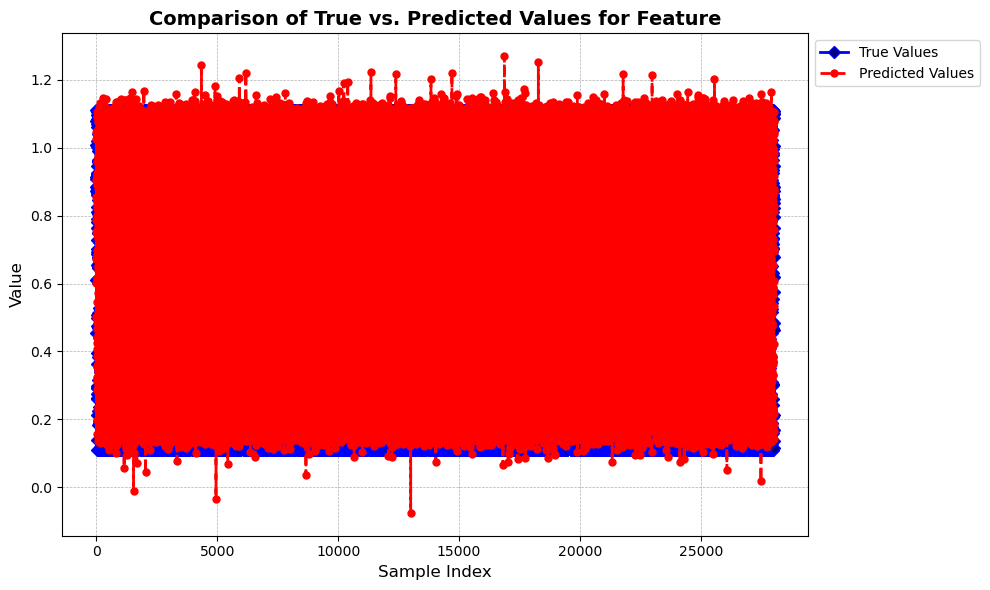

In [10]:
#Second Visualisation 

if results:
    # Initialise a figure for plotting with dimensions 10x6 inches for better visibility.
    plt.figure(figsize=(10, 6))
    
    # Plot the true values with a solid blue line and diamond markers.
    plt.plot(y_test_inverse[:, 0], 'b-',
             label='True Values', linewidth=2, marker='D', markersize=6, markerfacecolor='navy')
    
    # Plot the predicted values with a dashed orange line and circle markers.
    plt.plot(predictions_inverse[:, 0], 'r--',
             label='Predicted Values', linewidth=2, marker='o', markersize=5, markerfacecolor='red')
    
    # Set a more descriptive title to provide context.
    plt.title('Comparison of True vs. Predicted Values for Feature', fontsize=14, fontweight='bold')
    
    # Label axes with more detail.
    plt.xlabel('Sample Index', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    
    # Add a grid to the background for better readability.
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Add a legend with an optimal position outside the plot area.
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # Adjust layout to make room for the legend.
    plt.tight_layout()
    
    # Display the enhanced plot.
    plt.show()

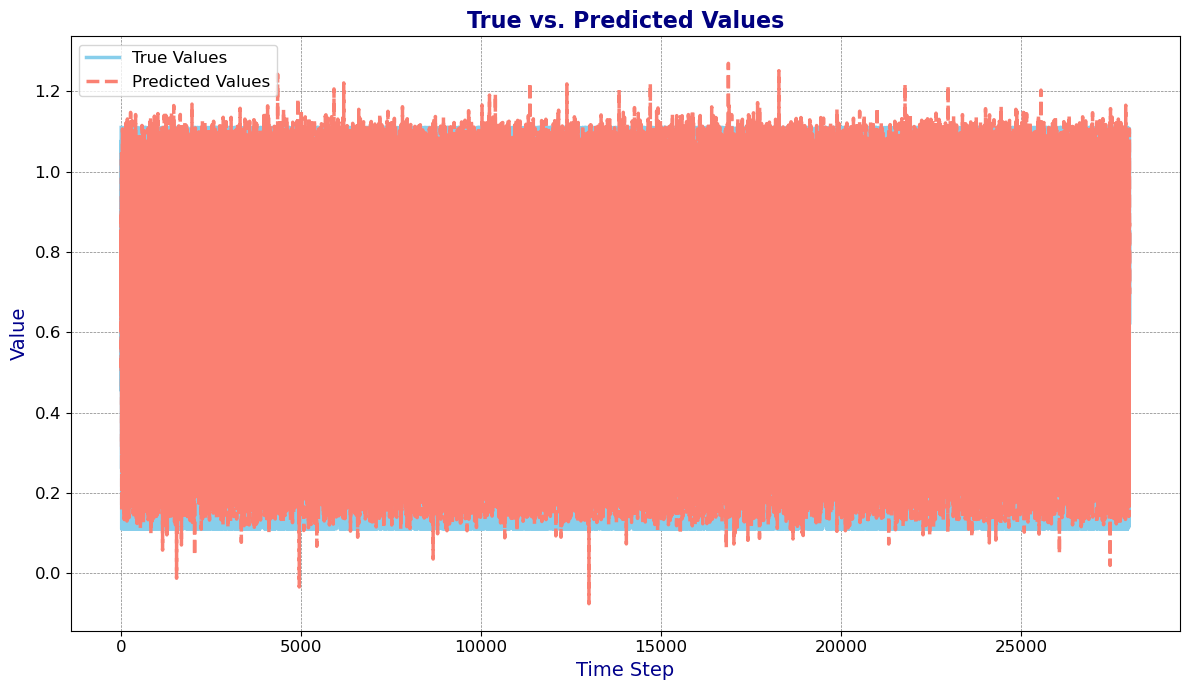

In [11]:
#Third Visualisation

if results:
    # Initialize the plot with a specific size for better visibility
    plt.figure(figsize=(12, 7))

    # Plot the true values using a solid line
    plt.plot(y_test_inverse[:, 0], label='True Values', color='skyblue', linewidth=2.5, linestyle='-')

    # Plot the predicted values using a different style
    plt.plot(predictions_inverse[:, 0], label='Predicted Values', color='salmon', linewidth=2.5, linestyle='--')

    # Adding some aesthetics to make the chart more readable and visually appealing
    plt.title('True vs. Predicted Values', fontsize=16, fontweight='bold', color='navy')
    plt.xlabel('Time Step', fontsize=14, color='darkblue')
    plt.ylabel('Value', fontsize=14, color='darkblue')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Enable grid for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')
    
    # Add a legend to help differentiate between true and predicted values
    plt.legend(loc='best', fontsize=12)

    # Ensure everything fits without clipping
    plt.tight_layout()

    # Display the plot
    plt.show()

In [15]:
if results:
    # Update the 'predictions' key in the results dictionary with model predictions on the test set.
    results['predictions'] = results['model'].predict(results['X_test'])
    
    # Apply inverse transformation back to their original scale.
    predictions_inverse = results['scaler'].inverse_transform(results['predictions'])
    y_test_inverse = results['scaler'].inverse_transform(results['y_test'])
    
    # Compile a DataFrame for a side-by-side comparison of true and predicted 'Open' values,
    # including the symbol associated with each prediction.
    comparison_df = pd.DataFrame({
        'Symbol': results['test_symbols'],  # Symbols associated with test data
        'True_Open': y_test_inverse[:, 0],  # True 'Open' values in original scale
        'Predicted_Open': predictions_inverse[:, 0],  # Predicted 'Open' values in original scale
        # Extend with more columns as necessary for additional comparison
    })
    
    # Display the first 100 rows of the comparison DataFrame for review.
    print(comparison_df.head(20))


876/876 [==============================] - 4s 4ms/step
    Symbol  True_Open  Predicted_Open
0   0HJF.L   1.110000        0.750627
1   MHPC.L   0.914348        0.853616
2   KEYS.L   0.872082        0.671867
3   0HCR.L   0.884038        0.786267
4    ROO.L   0.453750        0.501179
5   PMGR.L   0.906748        0.904467
6   ORCP.L   0.610000        0.601993
7   AGED.L   1.078254        1.024698
8   EDIN.L   1.008212        1.045952
9   SBIO.L   1.070954        1.027772
10  0G2Z.L   0.702751        0.745517
11  0KXO.L   0.686943        0.684044
12   ITX.L   0.260000        0.314650
13  DRDR.L   1.061709        0.922918
14   BMT.L   0.110000        0.157635
15   CRN.L   0.825517        0.802951
16  IBTL.L   0.868072        0.900268
17  0NW4.L   0.887750        0.849929
18  XT2D.L   0.395714        0.423859
19  0G91.L   0.879231        1.024502


In [13]:
def insert_predictions(insert_data):
    table_name = "dimension.predictive_Model6_results"
    # Define the SQL insert statement
    insert_query_template = f"""
    INSERT INTO {table_name} (
        Symbol, True_Open, True_High, True_Low, True_Close, True_Volume,
        Predicted_Open, Predicted_High, Predicted_Low, Predicted_Close, Predicted_Volume,
        DateTo)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
    """
    
    for row in insert_data:
        # Prepare the values for insertion
        values = (
            row["Symbol"],
            row["True_Open"], row["True_High"], row["True_Low"], row["True_Close"], row["True_Volume"],
            row["Predicted_Open"], row["Predicted_High"], row["Predicted_Low"], row["Predicted_Close"], row["Predicted_Volume"],
            row["DateTo"]
        )
        
        # Use the execute_sql_query function to insert the data
        execute_sql_query(insert_query_template, values)


In [14]:
if results:
    predictions_inverse = results['scaler'].inverse_transform(results['predictions'])
    y_test_inverse = results['scaler'].inverse_transform(results['y_test'])
    test_symbols = results['test_symbols']
    test_dates = results['test_dates']  # This now holds the prediction dates

    insert_data = []
    for i in range(len(predictions_inverse)):
        # Format test_dates[i] as needed, e.g., to string if it's not already
        prediction_date_str = test_dates[i].strftime('%Y-%m-%d')
        row = {
            "Symbol": test_symbols[i],
            "True_Open": round(float(y_test_inverse[i, 0]), 2),
            "True_High": round(float(y_test_inverse[i, 1]), 2),
            "True_Low": round(float(y_test_inverse[i, 2]), 2),
            "True_Close": round(float(y_test_inverse[i, 3]), 2),
            "True_Volume": round(float(y_test_inverse[i, 4]), 2),
            "Predicted_Open": round(float(predictions_inverse[i, 0]), 2),
            "Predicted_High": round(float(predictions_inverse[i, 1]), 2),
            "Predicted_Low": round(float(predictions_inverse[i, 2]), 2),
            "Predicted_Close": round(float(predictions_inverse[i, 3]), 2),
            "Predicted_Volume": round(float(predictions_inverse[i, 4]), 2),
            "DateTo": prediction_date_str
        }
        insert_data.append(row)

    # Now call insert_predictions with the prepared insert_data
    insert_predictions(insert_data)

